In [1]:
import torch
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score
import os
import sys
import time
import random
from torchvision import datasets, models, transforms
import torchvision.transforms as v2
import shutil
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torchvision.models as models

In [2]:
def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
seed_everything(42)
dataset_dir = "/workspace/folder01/pd/data"
filtered_dir = '/workspace/folder01/pd/datafil'
# split_data(dataset_dir, filtered_dir)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/workspace/folder01/pd/datafil/'

image_datasets = {
    'train': datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=data_transforms['val']),
    'test': datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)  # Test set doesn't need shuffling
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f'Number of classes: {len(class_names)}')
print(f'Class names: {class_names}')

Number of classes: 61
Class names: ['Apple___alternaria_leaf_spot', 'Apple___black_rot', 'Apple___brown_spot', 'Apple___gray_spot', 'Apple___healthy', 'Apple___rust', 'Apple___scab', 'Bell_pepper___bacterial_spot', 'Bell_pepper___healthy', 'Blueberry___healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease', 'Cherry___healthy', 'Cherry___powdery_mildew', 'Corn___common_rust', 'Corn___gray_leaf_spot', 'Corn___healthy', 'Corn___northern_leaf_blight', 'Grape___Leaf_blight', 'Grape___black_measles', 'Grape___black_rot', 'Grape___healthy', 'Grape___leaf_blight', 'Orange___citrus_greening', 'Peach___bacterial_spot', 'Peach___healthy', 'Potato___bacterial_wilt', 'Potato___early_blight', 'Potato___healthy', 'Potato___late_blight', 'Potato___nematode', 'Potato___pests', 'Potato___phytophthora', 'Potato___virus', 'Raspberry___healthy', 'Rice___bacterial_blight', 'Rice___blast', 'Rice___brown_spot', 'Rice_

In [6]:
num_classes = len(class_names) 
model = models.mnasnet1_0(weights='MNASNet1_0_Weights.DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth

00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.9M/16.9M [00:02<00:00, 6.44MB/s]

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3/4, gamma=0.5)

In [8]:
# # Function to set requires_grad for parameters
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        set_requires_grad(model, False) 
        for layer in model.children():
            if isinstance(layer, torch.nn.Sequential) and layer != model.classifier:
                for param in layer.parameters():
                    param.requires_grad = True
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            try:
                for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} epoch {epoch+1}'):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    if torch.isnan(loss):
                        print(f"NaN detected in loss at epoch {epoch+1} during {phase} phase")
                        return model, history
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error during {phase} phase in epoch {epoch+1}: {e}")
                return model, history
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_precision'].append(precision)
            history[f'{phase}_recall'].append(recall)
            history[f'{phase}_f1'].append(f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
        scheduler.step()
    return model, history



In [ ]:
trained_model, history = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25)
torch.save(trained_model, 'mnasnet.pth')
print("Model saved!")

In [ ]:
model=torch.load('./mnasnet.pth')
model = model.to(device)
model.eval()

test= transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_dataset = datasets.ImageFolder(root='/path/to/test', transform=test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed

# Define the loss function
criterion = nn.CrossEntropyLoss()

all_preds = []
all_labels = []
total_loss = 0.0

with torch.no_grad(): 
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  
        _, preds = torch.max(outputs, 1) 
        
        # Calculate and accumulate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)  # Multiply by batch size to accumulate total loss
        
        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss
avg_loss = total_loss / len(test_dataset)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print metrics and loss
print(f'Test Loss: {avg_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

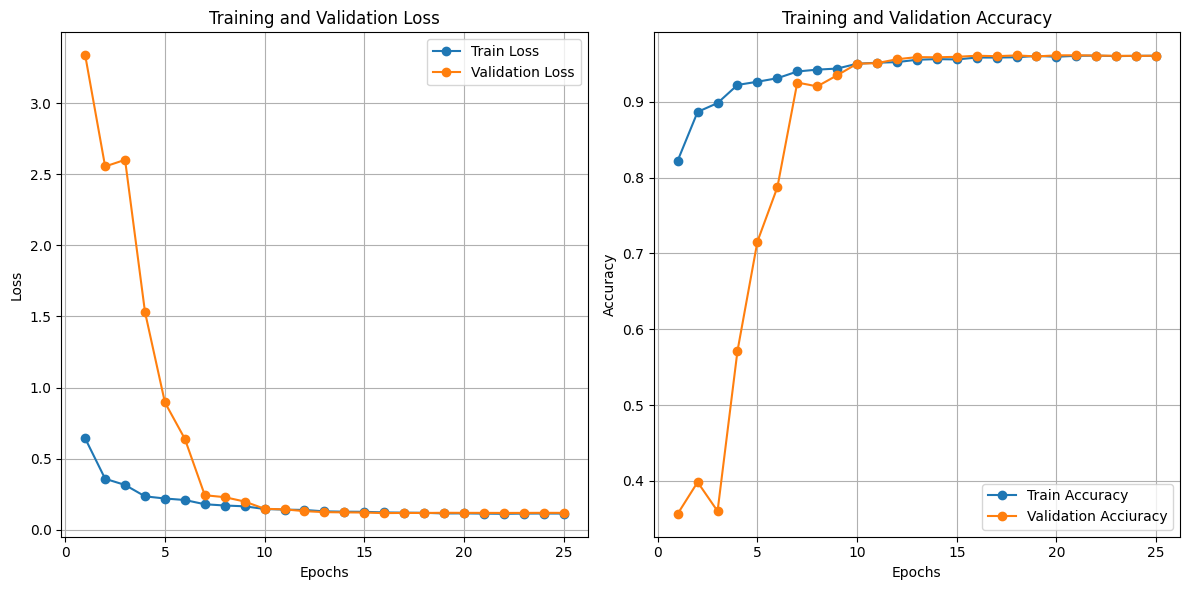

Training history plot saved at: /workspace/pd/training_history/training_history.png


/workspace/pd/training_history/training_history.png

In [14]:
import os
import matplotlib.pyplot as plt
from IPython.display import FileLink

# Define a function to plot and save training history
def plot_training_history(history, output_dir="/workspace/pd/training_history"):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Define the path for saving the image
    plot_path = os.path.join(output_dir, "training_history.png")

    epochs = range(1, len(history['train_loss']) + 1)

    # Create the figure
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Acciuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    # Provide a download link
    print(f"Training history plot saved at: {plot_path}")
    display(FileLink(plot_path))


plot_training_history(history)
